In [228]:
import uuid
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
import tifffile


In [266]:
from svgpathtools import Path, Line, QuadraticBezier, CubicBezier, Arc
from svgpathtools import svg2paths2, wsvg
from lxml import etree
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

In [13]:
from IPython.core.display import HTML, SVG, display

In [272]:
plt.rcParams['figure.dpi'] = 220

In [137]:
w, h = 1000, 1000

In [340]:
def load_svg(fp):
    drawing = svg2rlg(fp)
    renderPM.drawToFile(drawing, "tmp.png", fmt="PNG", )
    return skimage.io.imread('tmp.png')

def show_etching_paths(paths, w=1000, h=1000, color='#000000', background_img=None, save=None, stroke_width=1):
    r = etree.Element(
        "svg", width=str(int(w)), height=str(int(h)), xmlns="http://www.w3.org/2000/svg"
    )
    
#     if background_img is not None:
#         obj = etree.fromstring(f'<image xlink:href="{background_img}" width="100%" height="100%" x="0" y="0"/>')
#         r.append(obj)

    obj = etree.fromstring(f'<rect width="{w}" height="{h}" style="fill:rgb(0,0,0)" />')
    r.append(obj)
    
    for p in paths:
        i = uuid.uuid4()
        d = Path(p).d() if not isinstance(p, Path) else p.d()

        obj = etree.fromstring(f'<path id="{i}" stroke="#ffffff" fill="none" d="{d}" style="stroke-width:{stroke_width}"/>')
        r.append(obj)
    display_str = etree.tostring(r).decode('utf-8')
    
    if save is not None:
        f = open(save, 'w')
        f.write(display_str)
        f.close()
    
    display(SVG(display_str))

In [341]:
def random_lines(w, h, n=100, lens=(50, 100), angle=(0, 360)):
    paths = []
    for i in range(n):
        x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
        theta = np.random.randint(*angle) * 0.01745329
        mag = np.random.randint(*lens)
        
        x2, y2 = x1 + np.cos(theta) * mag, y1 + np.sin(theta) * mag
        x2, y2 = int(max(0, min(x2, w))), int(max(0, min(y2, h)))
                
        paths.append(Line(complex(x1, y1), complex(x2, y2)))
        
    return paths

def masked_lines(mask, n=100, lens=(50, 100), angle=(0, 360), weights=None):
    w, h = mask.shape[1], mask.shape[0]
    paths = []
    
    xs, ys = np.argwhere(mask)[:, 1], np.argwhere(mask)[:, 0]
    tups, idxs = list(zip(xs, ys)), np.arange(len(xs))
    if weights is not None:
        probs = weights[ys, xs]
        probs /= np.sum(probs)
    
    labels = skimage.measure.label(mask)
    
    count = 0
    while count < n:
        if weights is not None:
            x1, y1 = tups[np.random.choice(idxs, p=probs)]
        else:
            x1, y1 = tups[np.random.choice(idxs)]
            
        theta = np.random.randint(*angle) * 0.01745329
        mag = np.random.randint(*lens)

        x2, y2 = int(x1 + np.cos(theta) * mag), int(y1 + np.sin(theta) * mag)
        x2, y2 = max(0, min(x2, mask.shape[1] - 1)), max(0, min(y2, mask.shape[0] - 1))

        if labels[y2, x2] == labels[y1, x1] and labels[y1, x1] > 0:       
            paths.append(Line(complex(x1, y1), complex(x2, y2)))
            count += 1
        
    return paths

In [342]:
# paths = masked_lines(mask, n=1000, lens=(2, 10), angle=(35, 70), weights=1-gray)

In [361]:
m = skimage.morphology.erosion(mask)
# m = skimage.morphology.dilation(m)
# m = skimage.morphology.erosion(m)
paths = masked_lines(m, n=500, lens=(2, 10), angle=(35, 70), weights=gray)

In [356]:
# w = 1-gray
# w[w<.5] = 0.
# paths = masked_lines(np.full_like(mask, True), n=1000, lens=(2, 10), angle=(35, 70), weights=w)

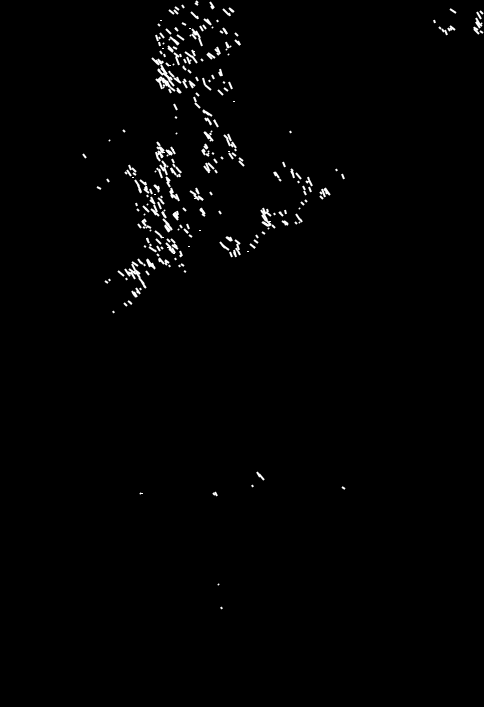

In [357]:
fp = 'temp.svg'
show_etching_paths(paths, mask.shape[1], mask.shape[0], save=fp, stroke_width=2.)

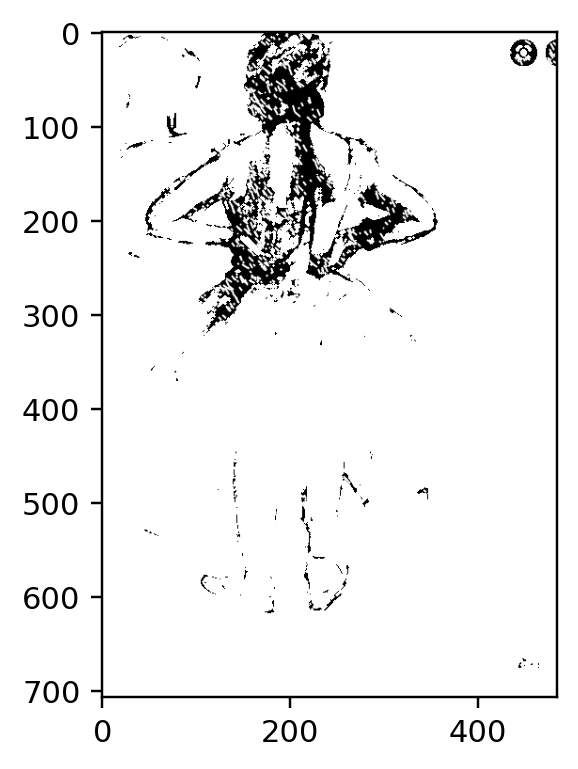

In [364]:
img = load_svg(fp)
img[~m] = 255
plt.imshow(img)

In [225]:
paths = random_lines(w, h, n=1000, lens=(2, 10), angle=(30, 40))

In [226]:
paths[2]

Line(start=(297+70j), end=(300+72j))

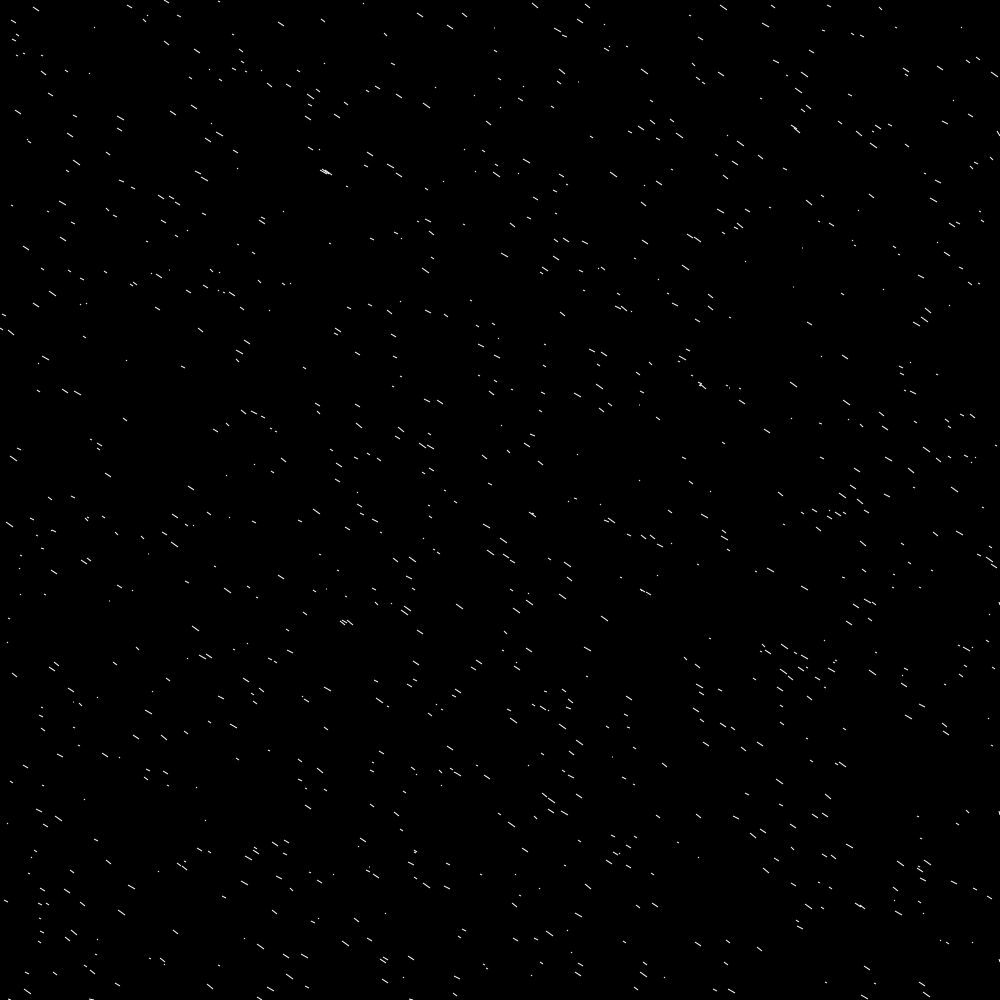

In [227]:
show_etching_paths(paths, w, h)

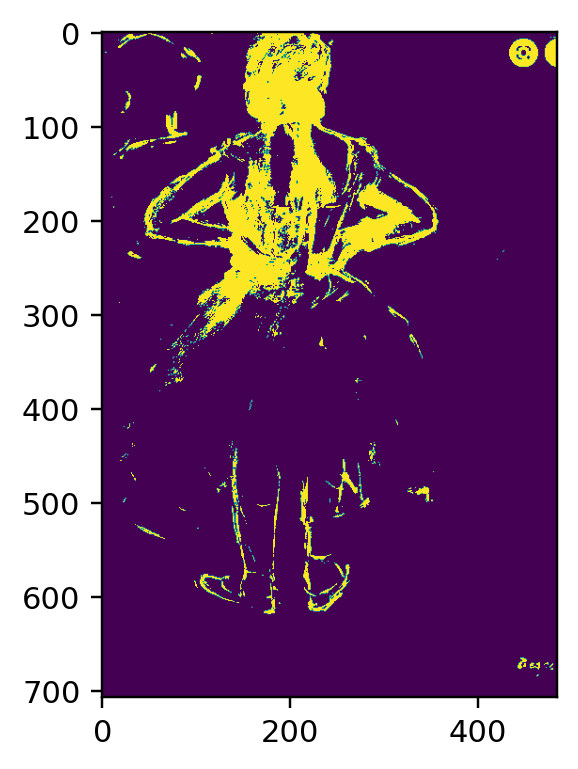

In [324]:
mask = tifffile.imread('../data/examples/degas_mask.tif')
plt.imshow(mask)

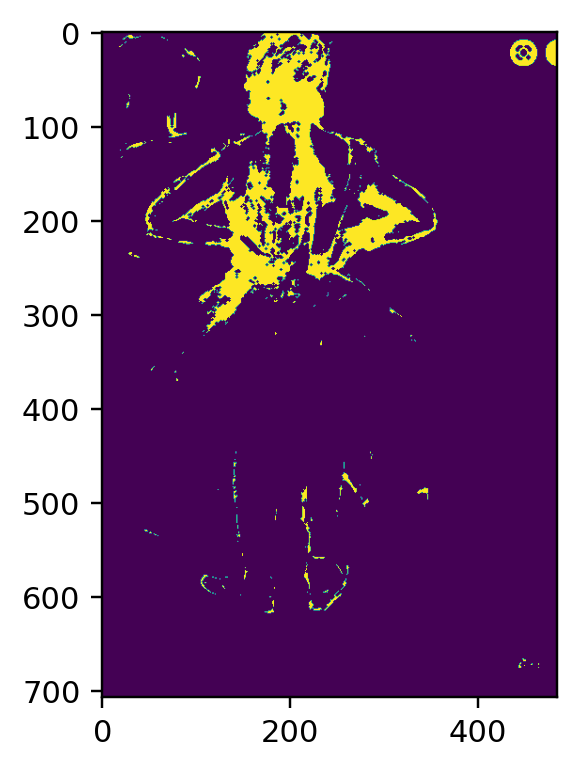

In [326]:
plt.imshow(skimage.morphology.erosion(mask))

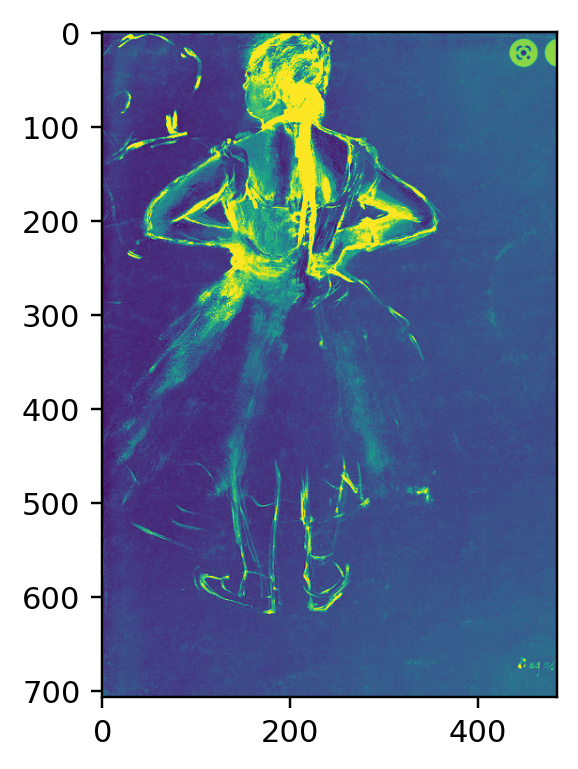

In [315]:
gray = tifffile.imread('../data/examples/degas_gray.tif')
plt.imshow(1 - gray, vmax=.8)